# Problem 4 - Trajectory Optimization for a planar arm

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [23]:
import numpy as np
from IPython.display import HTML, SVG, display
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys
import pydot

from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, LeafSystem
from pydrake.systems.planar_scenegraph_visualizer import ConnectPlanarSceneGraphVisualizer
from pydrake.systems.primitives import LogVectorOutput, WrapToSystem
from pydrake.all import StartMeshcat, MeshcatVisualizer, MeshcatVisualizerParams,VisualizationConfig, ApplyVisualizationConfig, FindResourceOrThrow

In [24]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7003


## Compute the end effector (the ball) position and velocity using symbolic variables

This is how we get the expression in `kinematic_constraints.py`

In [25]:
# Computes the end effector velocity as xdot, ydot J_q (pos) * qdot

from sympy import *
import numpy as np

l, q0, q1, qdot0, qdot1 = symbols('l q0 q1 qdot0 qdot1', real=True)
pos = l * Matrix([-sin(q0), -cos(q0)]) + \
      l * Matrix([-sin(q0 + q1), -cos(q0 + q1)])
vel = Matrix(pos).jacobian([q0, q1]) @ np.reshape(np.array([qdot0, qdot1]), (2,1))

print('pos (x_ball, z_ball):\n', pos)
print('')
print('vel (x_ball dot, z_ball dot):\n', vel)

pos (x_ball, z_ball):
 Matrix([[-l*sin(q0) - l*sin(q0 + q1)], [-l*cos(q0) - l*cos(q0 + q1)]])

vel (x_ball dot, z_ball dot):
 Matrix([[-l*qdot1*cos(q0 + q1) + qdot0*(-l*cos(q0) - l*cos(q0 + q1))], [l*qdot1*sin(q0 + q1) + qdot0*(l*sin(q0) + l*sin(q0 + q1))]])


## Set up Ball Trajectory

The ball is in the air for 1.012072360567372s


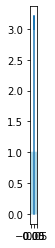

In [26]:
from matplotlib.patches import Wedge

g = 9.81

def CalcCatchPos(q0, v0, t_catch):
    y_final = q0[1] + v0[1] * t_catch
    x_final = q0[0] + v0[0] * t_catch
    z_final = q0[2] + v0[2] * t_catch - 0.5 * g * t_catch**2
    return np.array([x_final, y_final, z_final])

def tFall(q0, v0):
    # Solve 0 = q0[2] + v0[2] * t - 0.5 * g * t**2
    a = -0.5 * g
    b = v0[2]
    c = q0[2]
    return (-b - np.sqrt(b*b - 4*a*c)) / (2*a)

q0_ball = np.array([0, 0, 3])
v0_ball = np.array([0, 0, 2])

max_t = tFall(q0_ball, v0_ball)
print(f'The ball is in the air for {max_t}s')
plot_t = np.linspace(0, max_t, 50)
plot_q = np.array([CalcCatchPos(q0_ball, v0_ball, t) for t in plot_t])

fig, ax = plt.subplots()
plt.gca().set_aspect('equal')
ax.plot(plot_q[:,0], plot_q[:,2])
# ax.add_patch(plt.Circle((0,0), 1, color='lightblue'))
ax.add_patch(Wedge((0,0), 1, 0, 180, color='lightblue'))
plt.show()

## Run trajectory optimization to find the optimal trajectory

In [27]:
import importlib
import catching_trajectory
importlib.reload(catching_trajectory)
from catching_trajectory import find_throwing_trajectory

N = 5
initial_state = [0, 0, 0, -0.5, 0, 0, 0] + [0] * 7
final_configuration = np.array([np.pi, 0])
tf = 1
distance = 15.0

x_traj, u_traj, t_catch, prog, _, _ = find_throwing_trajectory(N, q0_ball, v0_ball, initial_state, final_configuration, distance)


n_q =  7
n_v =  7
n_x =  14
n_u =  7
[87. 87. 87. 87. 12. 12. 12.]
[2.175 2.175 2.175 2.175 2.61  2.61  2.61 ]
pos cur = 
 [[ 1.   0.  -0.   0.2]
 [ 0.  -1.   0.   0. ]
 [-0.  -0.  -1.   0.8]
 [ 0.   0.   0.   1. ]]
Solution is valid
ee pos rot =  [<AutoDiffXd -0.08681198225463829 nderiv=15>
 <AutoDiffXd 0.06307259704933153 nderiv=15>
 <AutoDiffXd 0.924941908030873 nderiv=15>
 <AutoDiffXd -0.08681198225463829 nderiv=15>
 <AutoDiffXd 0.06307259704933153 nderiv=15>
 <AutoDiffXd 0.924941908030873 nderiv=15>]
pos_vel_final =  [<AutoDiffXd 0.0 nderiv=15> <AutoDiffXd 0.0 nderiv=15>
 <AutoDiffXd 2.7737499999999997 nderiv=15> <AutoDiffXd 0.0 nderiv=15>
 <AutoDiffXd 0.0 nderiv=15> <AutoDiffXd -1.0 nderiv=15>]
ee pos rot =  [<AutoDiffXd -0.0868115226650409 nderiv=15>
 <AutoDiffXd 0.0630712465566945 nderiv=15>
 <AutoDiffXd 0.9249419139564232 nderiv=15>
 <AutoDiffXd -0.0868115226650409 nderiv=15>
 <AutoDiffXd 0.0630712465566945 nderiv=15>
 <AutoDiffXd 0.9249419139564232 nderiv=15>]
pos_vel_final =

## Validate the Solution

In [28]:
print('Ball Position', CalcCatchPos(q0_ball, v0_ball, t_catch).ravel())
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
Parser(plant).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("panda_link0"))
plant.Finalize()

context = plant.CreateDefaultContext()
context.SetContinuousState(x_traj.value(t_catch))
ee_frame = plant.GetBodyByName("panda_link8").body_frame()
ee_pos = plant.CalcPointsPositions(context, ee_frame, np.zeros(3), plant.world_frame()).ravel()
np.set_printoptions(suppress=True)
print('EE Position', ee_pos)

Ball Position [0.        0.        0.9309299]
EE Position [-0.        -0.         0.9309299]


## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import time

from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource,
    AddMultibodyPlantSceneGraph
)


# Create a MultibodyPlant for the arm
# file_name = "panda_arm.urdf"
builder = DiagramBuilder()
ball, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
# scene_graph = builder.AddSystem(SceneGraph())
panda_arm = builder.AddSystem(MultibodyPlant(0.0))
# panda_arm, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.)
panda_arm.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=panda_arm).AddModels("./panda_arm_custom.urdf")
# Parser(plant=panda_arm).AddModels(url="package://drake/manipulation/models/franka_description/urdf/panda_arm.urdf")
panda_arm.WeldFrames(panda_arm.world_frame(), panda_arm.GetFrameByName("panda_link0"))
panda_arm.Finalize()

# ball = builder.AddSystem(MultibodyPlant(0.0))
Parser(plant=ball).AddModels("./ball.urdf")
ball.Finalize()
# ball.RegisterAsSourceForSceneGraph(scene_graph)
# builder.Connect(ball.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(ball.get_source_id()))
# builder.Connect(scene_graph.get_query_output_port(), ball.get_geometry_query_input_port())

n_q = panda_arm.num_positions()
n_v = panda_arm.num_velocities()
n_u = panda_arm.num_actuators()

print("n_q = ", n_q)
print("n_v = ", n_v)
print("n_u = ", n_u)

x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(panda_arm))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), panda_arm.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(panda_arm.get_source_id()))
builder.Connect(scene_graph.get_query_output_port(), panda_arm.get_geometry_query_input_port())

MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
visualization_config = VisualizationConfig()
visualization_config.publish_contacts = True
visualization_config.publish_proximity = True
ApplyVisualizationConfig(visualization_config, builder, meshcat=meshcat)

diagram = builder.Build()
diagram.set_name("diagram")

# Visualize the motion for `n_playback` times
n_playback = 3
for i in range(n_playback):
  # Set up a simulator to run this diagram.
    context = diagram.CreateDefaultContext()
    ball.SetPositions(ball.GetMyContextFromRoot(context), [0, 0, 0, 1, *q0_ball])
    ball.SetVelocities(ball.GetMyContextFromRoot(context), [0, 0, 0, *v0_ball])
    simulator = Simulator(diagram, context)
    simulator.Initialize()
    time.sleep(1)
    simulator.set_target_realtime_rate(0.2)
    simulator.AdvanceTo(t_catch);
    time.sleep(1)

n_q =  7
n_v =  7
n_u =  7
